In [1]:
from utils import prepare_image_forgery_dataset

data_directory = '../data'

IMG_SIZE=(128, 128)

X_train, X_test, y_train, y_test = prepare_image_forgery_dataset(total_number=5000, test_size=0.2, random_state=42, 
                                                                 data_directory=data_directory, img_size=IMG_SIZE)

2024-07-08 18:25:59.292629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 18:25:59.292712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 18:25:59.293987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 18:25:59.302192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 18:26:00.145724: W tensorflow/compiler/tf2

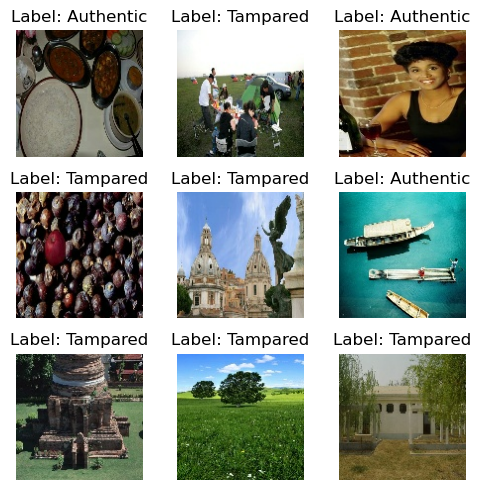

In [2]:
from utils import display_images

classnames = ['Authentic', 'Tampared']

display_images(X_train, y_train, classnames=classnames)

In [3]:
from sklearn.metrics import accuracy_score
from models.cnn import CNNImageForgeryDetector
from models.svm import SVMImageForgeryDetector
from models.fine_tuning import TransferLearningImageForgeryDetector

# base_models = [SVMImageForgeryDetector(use_edges=False, use_noise=False, use_texture=False, img_size=IMG_SIZE) for _ in range(10)]

# base_models = [TransferLearningImageForgeryDetector(img_size=IMG_SIZE, learning_rate=0.0001) for _ in range(1)] + \
#               [SVMImageForgeryDetector(use_edges=False, use_noise=False, use_texture=False, img_size=IMG_SIZE) for _ in range(1)] + \
#               [CNNImageForgeryDetector(img_size=IMG_SIZE, compression_quality=80, learning_rate=0.0001) for _ in range(1)]

base_models = [SVMImageForgeryDetector(use_edges=False, use_noise=False, use_texture=False, img_size=IMG_SIZE) for _ in range(5)]

In [4]:
from models.adaboosting import AdaBoostingImageForgeryDetector

boosting_model = AdaBoostingImageForgeryDetector(base_models, learning_rate=0.5)
boosting_model.fit(X_train, y_train)

/mnt/c/Escuela/Edited-Photo-Detection/notebooks/models/svm.py:64: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(f_shift))
/mnt/c/Escuela/Edited-Photo-Detection/notebooks/models/svm.py:64: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(f_shift))


In [ ]:
boosting_model.print_history()

In [ ]:
from utils import print_model_performance_metrics
y_pred = boosting_model.predict(X_test)
print_model_performance_metrics(y_test, y_pred)